In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import os
os.chdir('/home/hrai/codes/PoseAdaptor')
from hpe_library.lib_import import *
from hpe_library. my_utils import *

# 주요 디렉토리 경로
user = getpass.getuser()
alphapose_root = '/home/{}/codes/AlphaPose'.format(user)
motionbert_root = '/home/{}/codes/MotionBERT'.format(user)
kookmin_root = '/home/{}/Datasets/HAAI/국민대데이터/data'.format(user)
ap_kookmin_result_root = alphapose_root + "/examples/kookmin_result_5actions"

assert os.path.isdir(alphapose_root), "AlphaPose root directory is not exist"
assert os.path.isdir(motionbert_root), "MotionBERT root directory is not exist"
assert os.path.isdir(kookmin_root), "Kookmin root directory is not exist"
assert os.path.isdir(ap_kookmin_result_root), "AlphaPose Kookmin result directory is not exist"

alphapose_root, motionbert_root, kookmin_root, ap_kookmin_result_root

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


('/home/hrai/codes/AlphaPose',
 '/home/hrai/codes/MotionBERT',
 '/home/hrai/Datasets/HAAI/국민대데이터/data',
 '/home/hrai/codes/AlphaPose/examples/kookmin_result_5actions')

In [5]:
os.chdir(motionbert_root)
from lib.utils.tools import * # get_config
from lib.utils.learning import * # load_backbone

def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument("--config", type=str, default="configs/pose3d/MB_ft_h36m.yaml", help="Path to the config file.")
    parser.add_argument('-c', '--checkpoint', default='checkpoint', type=str, metavar='PATH', help='checkpoint directory')
    parser.add_argument('-p', '--pretrained', default='checkpoint', type=str, metavar='PATH', help='pretrained checkpoint directory')
    parser.add_argument('-r', '--resume', default='', type=str, metavar='FILENAME', help='checkpoint to resume (file name)')
    parser.add_argument('-e', '--evaluate', default='checkpoint/pose3d/MB_ft_h36m/best_epoch.bin', type=str, metavar='FILENAME', help='checkpoint to evaluate (file name)')
    parser.add_argument('-ms', '--selection', default='latest_epoch.bin', type=str, metavar='FILENAME', help='checkpoint to finetune (file name)')
    parser.add_argument('-sd', '--seed', default=0, type=int, help='random seed')
    parser.add_argument('-g', '--gpu', default='0', type=str, help='GPU id')
    #opts = parser.parse_args([])
    opts = parser.parse_args(['--evaluate', 'checkpoint/pose3d/FT_MB_release_kookmin_total_with_kookmin_setting_s0258_test/best_epoch.bin'])
    #opts = parser.parse_args(['--evaluate', 'checkpoint/pose3d/FT_MB_release_kookmin_total_with_kookmin_setting_s0258_test_sym10000/best_epoch.bin'])
    return opts

opts = parse_args()
args = get_config(opts.config)

In [6]:
model_backbone = load_backbone(args)
model_backbone = nn.DataParallel(model_backbone)
model_backbone = model_backbone.cuda()

chk_filename = opts.evaluate
print('Loading checkpoint', chk_filename)
checkpoint = torch.load(chk_filename, map_location=lambda storage, loc: storage)
model_backbone.load_state_dict(checkpoint['model_pos'], strict=True)
model_pos = model_backbone

Loading checkpoint checkpoint/pose3d/FT_MB_release_kookmin_total_with_kookmin_setting_s0258_test/best_epoch.bin


In [7]:
root_folder = '/home/hrai/Datasets/HAAI/국민대데이터/'
subject = 'S01'
action = 'squat'
phase = '001'
camera_id = 4

interpolate_spine = True
if interpolate_spine:
    necessary_joints = [ 0, 1, 3, 4, 5, 6, 7, 8, 13, 14, 15, 16, 17, 18, 19, 20] 
else:
    necessary_joints = [ 0, 1, 2, 3, 4, 5, 6, 7, 8, 13, 14, 15, 16, 17, 18, 19, 20] 

lbot = np.array([-0.53090762,  1.47796592,  0.00880748])
cam_param = readpkl('/home/hrai/Datasets/HAAI/국민대데이터/camera_parameter_estimation/' + 'cam_param.pkl')

# load vicon data
file_path = os.path.join(root_folder, 'data', 'gist data', '{}/{}_{}_{}.csv'.format(subject, subject, action, phase))
assert os.path.exists(file_path), "no csv file"

pose3d_list, attribute_list = load_pose3d_kookmin(subject, action, phase, lbot, h36m=False)  

# check available frames
available_frames, num_frames = check_available_frame(pose3d_list, necessary_joints, interpolate_spine)
assert available_frames != None, "No available frames"

# convert to h36m
pose3d_list_h36m = kookmin2h36m(pose3d_list) # 100fps
def sample_data(data, sample_ratio=0.5):
    sample_stride = int(1/sample_ratio) 
    return data[::sample_stride]
pose3d_list_h36m = sample_data(pose3d_list_h36m, sample_ratio=30/100)

# generate pkl 
H, W, R, t, C, calibration_matrix, image = get_cam_param_kookmin(cam_param, subject, camera_id)
camera_param = {
    'intrinsic': calibration_matrix,
    'extrinsic': np.concatenate([R, t.reshape(3, 1)], axis=1),
}

cam_proj = np.array(calibration_matrix) @ np.hstack([R, t])

/home/hrai/Datasets/HAAI/국민대데이터/data/gist data/S01/S01_squat_001.csv
Available frames: 0 ~ 1854


In [8]:
# dynamic rotation
pose3d_list_h36m_rotated = pose3d_list_h36m.copy()
for frame in range(len(pose3d_list_h36m_rotated)):
    rot = Rotation.from_rotvec([0, 0, frame/243*np.pi/6]).as_matrix() # 30 around z-axis at 243 frame
    pose3d_list_h36m_rotated[frame] = rotate_torso_by_R(pose3d_list_h36m[frame], rot)

pose_2d_list = projection(pose3d_list_h36m, cam_proj)
pose_2d_list_rotated = projection(pose3d_list_h36m_rotated, cam_proj)

In [9]:
input_data = pose_2d_list_rotated[:243].copy() # 243 frames
input_data = normalize_input(input_data, W, H) # normalize
input_data = torch.Tensor(input_data).unsqueeze(0) # to batch tensor
output = get_inference_from_motionbert(model_pos, input_data, args, W, H)[0]

(17, 3)


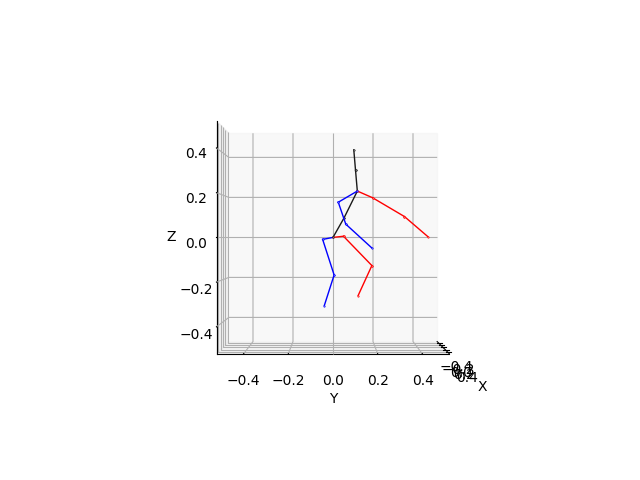

In [10]:
pose = get_rootrel_pose(output[200].copy()) # 1 frame
#pose = get_rootrel_pose(output[0].copy()) # 1 frame
print(pose.shape)
R1 = Rotation.from_rotvec([-np.pi/2, 0, 0]).as_matrix() # -90 around x-axis
R2 = Rotation.from_rotvec([0, 0, np.pi/2]).as_matrix() # 90 around z-axis
pose = rotate_torso_by_R(pose, R2 @ R1)

fig = plt.figure(10)
fig.clear()
ax = axes_3d(fig, xlim=(-0.5, 0.5), ylim=(-0.5, 0.5), zlim=(-0.5, 0.5))
draw_3d_pose(ax, pose)
plt.show()

In [12]:
save_h36m_pose_video(output, './S01_squat_4_dynamic_rot_result.mp4', pose_type='3d', dynamic_view=False)

  0%|          | 0/243 [00:00<?, ?it/s]

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1105, 829) to (1120, 832) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
100%|██████████| 243/243 [00:13<00:00, 18.50it/s]


In [15]:
save_h36m_pose_video(pose_2d_list_rotated[:243], './S01_squat_4_dynamic_rot_input.mp4', W=W, H=H, pose_type='2d', dynamic_view=False)

  0%|          | 0/243 [00:00<?, ?it/s]

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1080, 1920) to (1088, 1920) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x6ddedc0] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 243/243 [00:07<00:00, 34.64it/s]
